In [1]:
#Copyright 2022 Jesse Dimino, Benford's Law Fractal Geometry
#Data sets provided by Colin Fang

#packages needed to import
import os
import csv
import math
import numpy as np # linear algebra
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
import pandas as pd
from sklearn import linear_model 

In [2]:
#retruns the nth digit of a number (first digit by default)
def digit(num, n=1):
    if(num<0):
        num*=-1
    elif(num == 0):
        return 0
    while((num<1) & (num>0)):
        num*=10
    return int(num // 10 ** (int(math.log(num, 10)) - n + 1))

In [3]:
#PMF for Benford's law
BenfordProb = np.array([np.log10((i+1)/i) for i in range(1,10)])

In [4]:
#get the am and bm datasets
bm = pd.read_csv('bm_coeffs_10240_for_df.csv')

In [5]:
#drop all the zeros and reorder the indexes
bm = bm[bm["Numerator"] != '0']
bm = bm.reset_index(drop = True)

In [6]:
#get the number of nonzero data points (i.e. the number of tests performed)
len(bm)

10046

In [7]:
#add a column for decimal values
bm["Decimal"] = 0
for i in range(len(bm)):
    bm.at[i,"Decimal"] = int(bm.at[i,"Numerator"])/int(bm.at[i,"Denominator"])

In [8]:
#set our dataframe to be the am coefficient data
data = bm.copy()

In [9]:
#vectors to store the occurences of each digit
#specifically stores a running total of the observed digits from the data used up to that point
obs = pd.DataFrame()
obs["Num"] = [0 for i in range(1,10)] 
obs["Den"] = [0 for i in range(1,10)]
obs["Dec"] = [0 for i in range(1,10)]
#vectors to store chi square values
chisqu = pd.DataFrame()
chisqu["Num"] = [0 for i in range(len(data))]
chisqu["Den"] = [0 for i in range(len(data))]
chisqu["Dec"] = [0 for i in range(len(data))]

In [10]:
#loop to count the occurences of each digit and compute the chi squared statistic for data
d = 0
for i in range(len(data)):
    expec = (i+1)*BenfordProb #expected number of occurences for each digit
    d = digit(int(data.at[i,"Numerator"])) #get the first digit of the ith data point
    obs.at[d-1,"Num"] +=1 #increment the index of that digit
    chisqu.at[i,"Num"] = stats.chisquare(obs["Num"],expec)[0] #compute the chi squared statistic
    d = digit(int(data.at[i,"Denominator"]))
    obs.at[d-1,"Den"] +=1
    chisqu.at[i,"Den"] = stats.chisquare(obs["Den"],expec)[0]
    d = digit(float(data.at[i,"Decimal"]))
    obs.at[d-1,"Dec"] +=1
    chisqu.at[i,"Dec"] = stats.chisquare(obs["Dec"],expec)[0]

In [12]:
#show the final data rounded to v decimal places
v = 3
round(chisqu.iloc[len(data)-1],v) 

Num    12.785
Den     3.093
Dec    51.934
Name: 10045, dtype: float64

In [13]:
pvals = stats.distributions.chi2.sf(chisqu.iloc[len(data)-1],8)#get the p-values with the associated chi squared values
criticalThreshold = stats.chi2.isf(0.05, 8) #original threshold for significance
BonferroniCorrection = stats.chi2.isf(0.05/len(data), 8) #final corrected value
BonferroniCurve = [stats.chi2.isf(0.05/(i+1), 8) for i in range(len(data))] #Bonferroni Correction Curve for visuals
m = [(i+1) for i in range(len(data))] #m for plotting

In [14]:
0.05/len(data) #significance level for individual hypothesis

4.977105315548478e-06

In [15]:
pvals #[numerators, denominators, decimals]

array([1.19474967e-01, 9.28356721e-01, 1.73324795e-08])

In [16]:
pvals < 0.05 #whether we reject the null hyopthesis based on the overall test

array([False, False,  True])

In [23]:
pvals < (0.05/len(data)) #whether we reject the null hypothesis viewing the tests individually

array([False, False,  True])

In [18]:
#show the final data rounded to v+1 decimal places
round(criticalThreshold,v+1) 

15.5073

In [19]:
#show the final data rounded to v+1 decimal places
round(BonferroniCorrection,v+1)

38.9708

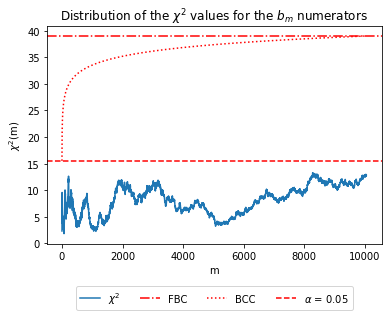

In [20]:
#plot the figure for the data
fig, ax = plt.subplots()
plt.plot(m,chisqu["Num"])
plt.axhline(y=BonferroniCorrection, color = 'r', linestyle = '-.')
plt.plot(m,BonferroniCurve,color = 'r', linestyle = ':')
plt.axhline(y=criticalThreshold,color = 'r', linestyle = '--')
plt.xlabel("m")
plt.ylabel("$\chi^2$(m)")
plt.title("Distribution of the $\chi^2$ values for the $b_m$ numerators")
lgd = plt.legend([r"$\chi^2$","FBC","BCC",r'$\alpha$ = 0.05'], loc = 10, bbox_to_anchor= (0.5,-0.25), ncol= 4)
#plt.savefig('ChiSquBMNum.eps', bbox_extra_artists=(lgd,), bbox_inches='tight') #save the figure

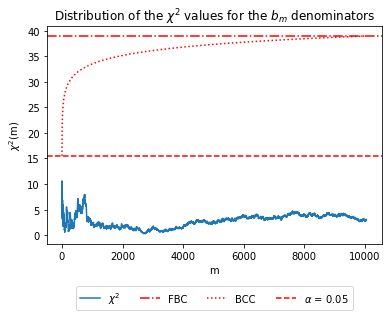

In [21]:
#plot the figure for the data
plt.plot(m,chisqu["Den"])
plt.axhline(y=BonferroniCorrection, color = 'r', linestyle = '-.')
plt.plot(m,BonferroniCurve,color = 'r', linestyle = ':')
plt.axhline(y=criticalThreshold,color = 'r', linestyle = '--')
plt.xlabel("m")
plt.ylabel("$\chi^2$(m)")
plt.title("Distribution of the $\chi^2$ values for the $b_m$ denominators")
lgd = plt.legend([r"$\chi^2$","FBC","BCC",r'$\alpha$ = 0.05'], loc = 10, bbox_to_anchor= (0.5,-0.25), ncol= 4)
#plt.savefig('ChiSquBMDen.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

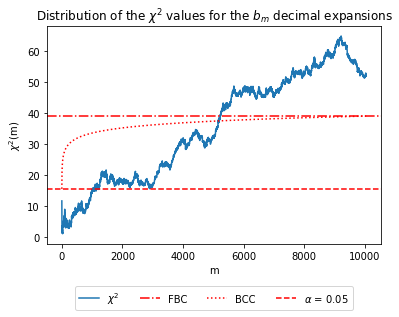

In [22]:
#plot the figure for the data
plt.plot(m,chisqu["Dec"])
plt.axhline(y=BonferroniCorrection, color = 'r', linestyle = '-.')
plt.plot(m,BonferroniCurve,color = 'r', linestyle = ':')
plt.axhline(y=criticalThreshold,color = 'r', linestyle = '--')
plt.xlabel("m")
plt.ylabel("$\chi^2$(m)")
plt.title("Distribution of the $\chi^2$ values for the $b_m$ decimal expansions")
lgd = plt.legend([r"$\chi^2$","FBC","BCC",r'$\alpha$ = 0.05'], loc = 10, bbox_to_anchor= (0.5,-0.25), ncol= 4)
#plt.savefig('ChiSquBMDec.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')